In [1]:
#Imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# own utils
from utils.graph_utils import *


# Data


- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

In [2]:
DATA_PATH = "/home/bule/TramDag/data"

### Example 1 SoCal , California House Prices

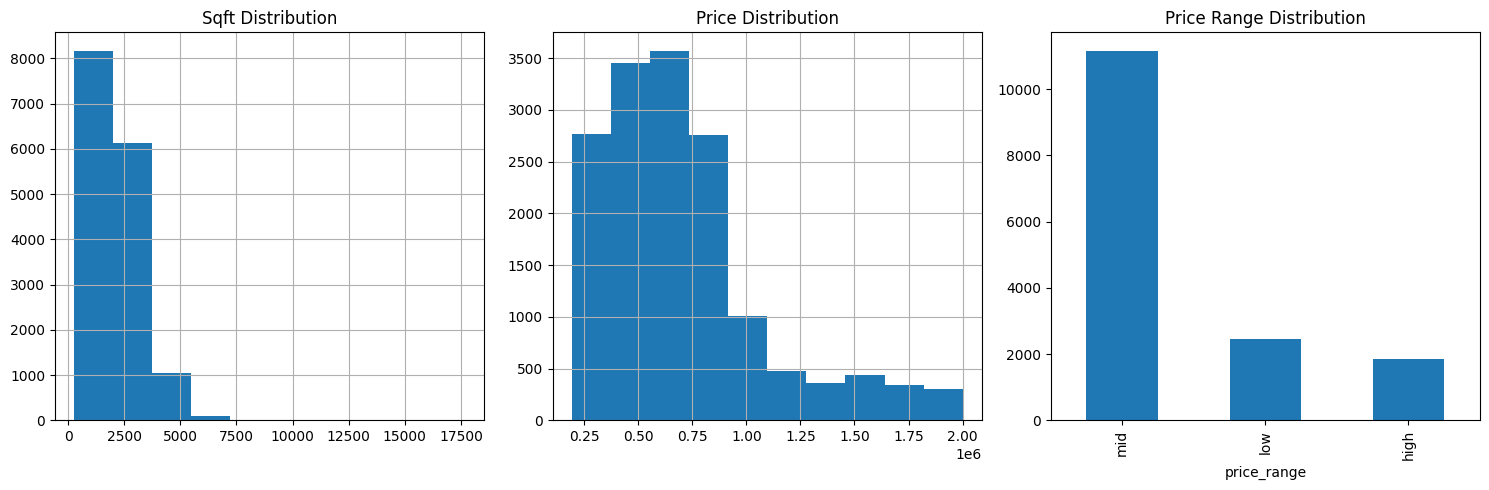

,image_id,street,citi,n_citi,bed,bath,sqft,price,images,price_range,price_range_int
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900,/home/bule/TramDag/data/socal2/socal_pics/1183...,low,0
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500,/home/bule/TramDag/data/socal2/socal_pics/68.jpg,low,0
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950,/home/bule/TramDag/data/socal2/socal_pics/7463...,low,0
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000,/home/bule/TramDag/data/socal2/socal_pics/2530...,low,0
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100,/home/bule/TramDag/data/socal2/socal_pics/2001...,mid,1


In [3]:
# toy example  https://www.kaggle.com/datasets/ted8080/house-prices-and-images-socal

# import kagglehub
# kagglehub.dataset_download("ted8080/house-prices-and-images-socal", path=DATA_PATH)

# X0 sqrft continous
# X1 Images
# X2 Price in ranges low, mid , high 
houses_df=pd.read_csv(os.path.join(DATA_PATH ,"socal2.csv"))


### X0 -> squarfoot continous

### X1 -> images -> path to images
image_paths=[os.path.join(DATA_PATH,"socal2/socal_pics",pth) for pth in os.listdir(os.path.join(DATA_PATH, "socal2/socal_pics"))]
houses_df['images']=image_paths

### X2 prices -> ordinal -> low, mid, high -> map to 0,1,2
houses_df['price_range'] = pd.cut(
    houses_df['price'], 
    bins=[0, 350_000, 1_100_000, float('inf')],  # Adjust bin edges
    labels=['low', 'mid', 'high'],  
    include_lowest=True  # Ensures 0 is included in 'low'
)
houses_df['price_range_int'] = houses_df['price_range'].map({'low': 0, 'mid': 1, 'high': 2})  # Encode labels


# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
houses_df['sqft'].hist(ax=axes[0])
axes[0].set_title('Sqft Distribution')
houses_df['price'].hist(ax=axes[1])
axes[1].set_title('Price Distribution')
houses_df['price_range'].value_counts().plot(kind='bar', ax=axes[2])
axes[2].set_title('Price Range Distribution')
plt.tight_layout()
plt.show()
houses_df.head(5)

### train test split

In [4]:
# train
train_df, temp_df = train_test_split(houses_df, test_size=0.2, stratify=houses_df['price_range_int'], random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['price_range_int'], random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 12379, Validation size: 1547, Test size: 1548


# Define graph Structure

- define graph and which shift and intercept terms to use


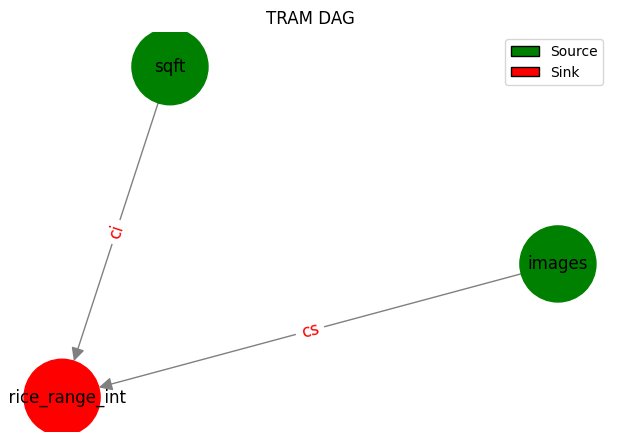

In [5]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 

# TODO support for interactions in CI model eg CI_1

# Example 1  Socal, sqft images price_range   3x3: 
# data_type={'X0':'cont','X1':'other','X2':'ord'}  # continous , images , ordinal
data_type={'sqft':'cont','images':'other','price_range_int':'ord'}  # continous , images , ordinal
adj_matrix = np.array([
    [ "0", "0", "ci"],  # A -> B (cs), A -> C (ls)
    [ "0", "0", "cs"],  # B -> D (ls)
    [ "0", "0", "0"],  # C -> D (cs)
], object)


# # example 2 4x4
# data_type={'X0':'other','X1':'ord','X2':'ord','X3':'ord'}  # images, continous, continous, continous    
# adj_matrix = np.array([
#                                 ["0", "ci", "ls", "ci"],  # A -> B (cs), A -> C (ls)
#                                 ["0", "0", "0", "ls"],  # B -> D (ls)
#                                 ["0", "0", "0", "cs"],  # C -> D (cs)
#                                 ["0", "0", "0", "0"]    # No outgoing edges from D
#                             ], dtype=object)


plot_dag(adj_matrix,data_type, seed=42)

# Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


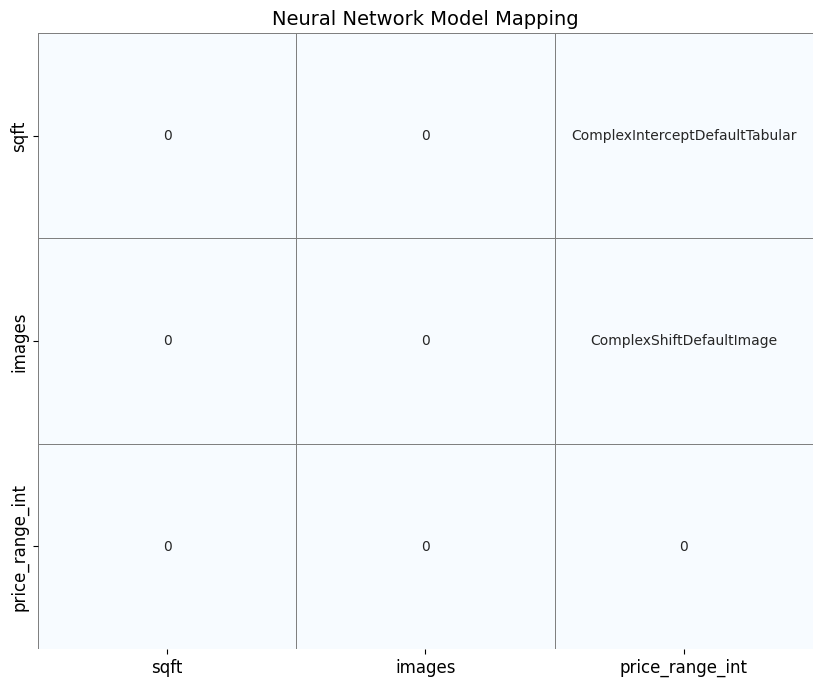

In [6]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

- add custom models for the ci or cs

In [7]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# rename the modelnames in the nn_names_matrix
# e.g.nn_names_matrix[2,3]='ComplexInterceptCUSTOMImage'  

- model configurations

In [8]:
conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
conf_dict

{'sqft': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': [],
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {}},
 'images': {'Modelnr': 1,
  'data_type': 'other',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': [],
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {}},
 'price_range_int': {'Modelnr': 2,
  'data_type': 'ord',
  'node_type': 'sink',
  'parents': ['sqft', 'images'],
  'parents_datatype': ['cont', 'other'],
  'transformation_terms_in_h()': {'sqft': 'ci', 'images': 'cs'},
  'transformation_term_nn_models_in_h()': {'sqft': 'ComplexInterceptDefaultTabular',
   'images': 'ComplexShiftDefaultImage'}}}

## Fit models

- each model independently fitting

In [9]:
from utils.ontram_models import *
from utils.ontram_data import *
from torchvision import transforms


In [23]:
for node in conf_dict:
    print(f'\n----------node: {node}--------')
    
    
    
    ######################################################## 1. Create Ontram Model ######################
    # TODO add args to the models via config file eg nn_int = globals()[nn_int_name](args) , args from conf
    
    
    #*************
    # aligning with code from lisa the ontram model takes a nn_int and a list of nn_shifts
    # -> nn_int is the intercept term
    # -> nn_shifts is a list of models that are used for the shift terms
    # if there are no shift terms, nn_shifts is None
    #**********
    
    ### iF node is a source -> no deep nn is needed
    if conf_dict[node]['node_type'] == 'source':
        print('>>>>>>>>>>>>  source node --> only  modelled only  by si')
        nn_int = SimpleIntercept()
        ontram_model = TramModel(nn_int, None)  
        print(ontram_model)
        
    ### if node is not a source node 
    else:
        # read terms and model names form the config
        terms_dict=conf_dict[node]['transformation_terms_in_h()']
        model_names_dict=conf_dict[node]['transformation_term_nn_models_in_h()']
        
        # Combine terms and model names and divide in intercept and shift terms
        model_dict=merge_transformation_dicts(terms_dict, model_names_dict)
        intercepts_dict = {k: v for k, v in model_dict.items() if "ci" in v['h_term'] or 'si' in v['h_term']}        
        shifts_dict = {k: v for k, v in model_dict.items() if "ci" not in v['h_term'] and  'si' not in v['h_term']}        
        
        # make sure that nns are correctly defined afterwards
        nn_int, nn_shifts_list = None, None
        
        # intercept term
        if not np.any(np.array([True for diction in intercepts_dict.values() if 'ci' in diction['h_term']]) == True):
            print('>>>>>>>>>>>> No ci detected --> intercept defaults to si')
            nn_int = SimpleIntercept()
        
        else:
            
            # intercept term -> model
            nn_int_name = list(model_names_dict.items())[0][1]
            nn_int = globals()[nn_int_name]()
        
        # shift term -> lsit of models         
        nn_shift_names=[v["class_name"] for v in shifts_dict.values() if "class_name" in v]
        nn_shifts_list = [globals()[name]() for name in nn_shift_names]
        
        # ontram model
        tram_model = TramModel(nn_int, nn_shifts_list)    
        print(tram_model)
        

    ##################################################### 2. Create Dataloaders ######################
    
    
    # TODO move transform to config file
    transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])
    
    
    
    if conf_dict[node]['node_type'] == 'source':
        print('>>>>>>>>>>>>  source node --> Datalaoder only consists of target')
        
        train_dataset = GenericDataset(train_df, target_col=node, data_type=None, transform=transform)
        validation_dataset = GenericDataset(train_df, target_col=node, data_type=None, transform=transform)
        
    
    else:
        
        parents_dict={x[0]:x[1] for x  in  zip(conf_dict[node]['parents'],conf_dict[node]['parents_datatype'])}
        
        train_dataset = GenericDataset(train_df, target_col=node, data_type=parents_dict, transform=transform)
        validation_dataset = GenericDataset(train_df, target_col=node, data_type=parents_dict, transform=transform)
     
     
    # TODO add args to the datloader via config file    
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
    val_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=4)
    
    
    
        



----------node: sqft--------
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> Datalaoder only consists of target

----------node: images--------
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> Datalaoder only consists of target

----------node: price_range_int--------
TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=1, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultImage(
      (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxP

In [24]:
tram_model

TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=1, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultImage(
      (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=16384, out_features=120, bias=True)
      (fc2): Linear(in_features=120, out_features=84, bias=True)
      (fc3): Linear(in_features=84, out_features=1, bias=False)
    )
  )
)

In [12]:
optimizer=None
use_scheduler=True
epochs=100



if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")
    
if optimizer is None:
    optimizer = torch.optim.Adam(tram_model.parameters(), lr=0.001, eps=1e-7, weight_decay=0.0)
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
    

Train with GPU support.


In [27]:
from utils.loss_ordinal import *

In [ ]:
# TODO check outputs of dataloader  onehot? cont? d type

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# TODO check input for nll
for x, y in train_loader:
    # Move all inputs to the correct device
    x[0] = x[0].to(device)  # Tabular data input
    x[1:] = [xi.to(device) for xi in x[1:]]  # Image inputs

    # Ensure y is an integer before one-hot encoding
    y = y.to(device).long()  # Convert y to LongTensor
    y = F.one_hot(y, num_classes=3).float()  # Convert to one-hot and ensure float dtype
    
    print(y)  # Debugging output

    # Ensure model is also on the correct device
    tram_model.to(device)

    tram_model.train()
    optimizer.zero_grad()
    
    # Pass tensors correctly to the model
    y_pred = tram_model(int_input=x[0], shift_input=x[1:])
    
    loss = ontram_nll(y_pred, y)
    print(loss)
    
    break



tensor([[0., 1., 0.]], device='cuda:0')


IndexError: too many indices for tensor of dimension 1

In [17]:
for x, y in train_loader:
    x[0] = x[0].to(device)  # Tabular input
    x[1:] = [xi.to(device) for xi in x[1:]]  # Image inputs

    print(f"int_input shape: {x[0].shape}, device: {x[0].device}")
    print(f"shift_input type: {type(x[1:])}, length: {len(x[1:])}")

    for i, xi in enumerate(x[1:]):
        print(f"shift_input[{i}] shape: {xi.shape}, device: {xi.device}")

    # Ensure shift_input is a list
    y_pred = ontram_model(x[0], list(x[1:]))
    
    print(y_pred)  # Check outputs
    break

int_input shape: torch.Size([1]), device: cuda:0
shift_input type: <class 'list'>, length: 1
shift_input[0] shape: torch.Size([1, 3, 128, 128]), device: cuda:0
{'int_out': tensor([ 871.2250,   62.1641,  530.1184,  627.6949,  -23.8813, -789.5381,
        -582.1821, -901.6315,  964.3674,  795.4030,  136.1655,  229.3913,
         102.8252,  959.2577, -616.8716, -261.0710, -694.2376,  -25.1945,
         360.5708,  538.2505], device='cuda:0', grad_fn=<SqueezeBackward4>), 'shift_out': None}


In [18]:
print(f"x[0] shape: {x[0].shape}, device: {x[0].device}")
for i, xi in enumerate(x[1:]):
    print(f"x[{i+1}] shape: {xi.shape}, device: {xi.device}")
print(f"y shape: {y.shape}, device: {y.device}")


x[0] shape: torch.Size([1]), device: cuda:0
x[1] shape: torch.Size([1, 3, 128, 128]), device: cuda:0
y shape: torch.Size([1]), device: cpu


In [19]:

optimizer.zero_grad()

In [20]:

if data_type == 'ord':
    best_val_loss = float('inf')
    train_loss_hist = []
    val_loss_hist = []
    
    
    for epoch in range(epochs):
    
    
    


    # model to device
    ontram_model.to(device)

    
    
    for x_list,y_tensor in train_loader:
        
        
        


IndentationError: expected an indented block (1830374399.py, line 14)

In [ ]:
x is a tuple 

In [ ]:
# No shift term -----------------------------------------------------------------------
        if model.nn_shift is None:
            for epoch in range(epochs):
                # Training phase -------------------
                model.train()
                train_loss = 0.0
                for y_tr in train_loader:
                    y_tr = y_tr[0]
                    y_tr = y_tr.to(device)

                    optimizer.zero_grad()

                    # Forward pass
                    int_tr = torch.from_numpy(np.ones(shape=[len(y_tr),1])).float()
                    int_tr = int_tr.to(device)
                    y_pred = model(int_tr)
                    loss = ontram_nll(y_pred, y_tr)

                    # Backward pass
                    loss.backward() 
                    optimizer.step()

                    train_loss += loss.item()

                avg_train_loss = train_loss/len(train_loader)
                train_loss_hist.append(avg_train_loss)

                # Validation phase -------------------
                if val_loader is not None:
                    model.eval()
                    val_loss = 0.0
                    # No gradient computation
                    with torch.no_grad():
                        for y_val in val_loader:
                            y_val = y_val[0]
                            y_val = y_val.to(device)

                            # Forward pass
                            int_val = torch.from_numpy(np.ones(shape=[len(y_val),1])).float()
                            int_val = int_val.to(device)
                            y_pred = model(int_val) 
                            loss = ontram_nll(y_pred, y_val)

                            val_loss += loss.item()

                    avg_val_loss = val_loss/len(val_loader)
                    val_loss_hist.append(avg_val_loss)

                    # Save model
                    if checkpoint_path is not None:
                        if avg_val_loss < best_val_loss:
                            best_val_loss = avg_val_loss
                            torch.save({'epoch': epoch,
                                        'model_state_dict': model.state_dict(),
                                        'optimizer_state_dict': optimizer.state_dict(),
                                        'val_loss': avg_val_loss,
                                        },
                                        checkpoint_path)
                else:
                    avg_val_loss = 0.0

                # Scheduler
                if use_scheduler:
                    scheduler.step()
                    print(f"New lr: {scheduler.get_last_lr()[0]}")
                
                # Epoch output ------------------------
                print(
                    f"Epoch {epoch + 1}/{epochs}, "
                    f"Train Loss: {avg_train_loss:.4f}, "
                    f"Validation Loss: {avg_val_loss:.4f}"
                )